## An Illuminating Example 

Let us consider the following toy dataset below where we have $x \in \mathbb{R}^{100}$ and $f^*(x) = x_1 x_2$.  This is known as a low-rank polynomial and more generally can be thought of as a function of the form $f^*(x) = g(U^T x)$.  In our example below, $U \in \mathbb{R}^{100 \times 2}$ with $U^T = \begin{bmatrix} 1 &  0 &  0 & \ldots &  0 \\ 0 &  1 &  0 & \ldots &  0 \end{bmatrix}$ and $g: \mathbb{R}^{2} \to \mathbb{R}$ with $g(u, v) = uv $.

In [1]:
import numpy as np

# Don't forget to set your random seeds so that experiments are all reproducible
SEED = 1717
np.random.seed(SEED)

d = 100

def sample_data(num_samples):
    X = np.random.normal(size=(num_samples, d))
    y = X[:, 0] * X[:, 1]
    return X, y.reshape(-1, 1)

n_train, n_test = 2000, 10000
X_train, y_train = sample_data(n_train)
X_test, y_test = sample_data(n_test)

### Train Laplace Kernel on the above dataset

Below, we solve kernel regression using the Laplace kernel on this dataset. 

In [2]:
from numpy.linalg import solve 

def euclidean_distances(samples, centers, squared=True):
    samples_norm = np.sum(samples**2, axis=1, keepdims=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = np.sum(centers**2, axis=1, keepdims=True)
    centers_norm = np.reshape(centers_norm, (1, -1))
    distances = samples @ centers.T
    distances *= -2
    distances = distances + samples_norm + centers_norm
    if not squared:
        distances = np.where(distances < 0, 0, distances)
        distances = np.sqrt(distances)

    return distances

def laplacian(samples, centers, bandwidth):
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers, squared=False)
    kernel_mat = np.where(kernel_mat < 0, 0, kernel_mat)
    gamma = 1. / bandwidth
    kernel_mat *= -gamma
    kernel_mat = np.exp(kernel_mat)
    return kernel_mat

class LaplaceKernel():

    def __init__(self, L=10):
        self.sol = None
        self.L = L
        self.X_train = None

    def fit(self, X, y, reg=0):
        self.X_train = X
        K = laplacian(X, X, self.L)
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        K = laplacian(self.X_train, X, self.L)
        return (self.sol @ K).T

In [3]:
from sklearn.metrics import r2_score

model = LaplaceKernel()
model = model.fit(X_train, y_train, reg=0)
lap_train_preds = model.predict(X_train)
lap_test_preds = model.predict(X_test)
lap_train_r2 = r2_score(y_train, lap_train_preds)
lap_test_r2 = r2_score(y_test, lap_test_preds)
print("Train R2: ", lap_train_r2, "Test R2: ", lap_test_r2)

Train R2:  1.0 Test R2:  0.07896651498580398


We observe an unusally low test $R^2$.  What is going on and did we make a mistake somewhere?

A good sign that we did not make a mistake is that the training $R^2$ is $1$.  Moreover, there are only two steps in the above code - ```model.fit``` and ```model.predict```.  Let us now train another model to see if performance improves.  

### Training a Fully Connected Neural Network on the above dataset

Below we train a 1 hidden layer FCNN with no bias term on the above samples.

In [4]:
import torch
from torch.utils.data import DataLoader

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

trainset = list(zip(X_train, y_train))
testset = list(zip(X_test, y_test))

In [5]:
# Set up data loaders for training neural networks
train_loader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=1)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=1)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# I typically abstract away nonlinearity so that I can change it easily if needed
class Nonlinearity(nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return F.relu(x)

# Build a simple 1 hidden layer FC net.  
class Net(nn.Module):

    def __init__(self, input_dim, target_dim):
        super(Net, self).__init__()
        bias = False
        k = 128
        self.input_dim = input_dim
        self.target_dim = target_dim
        self.width = k
        self.first = nn.Linear(input_dim, k, bias=bias)
        self.last = nn.Linear(k, target_dim, bias=bias)

    def forward(self, x):
        return self.last(F.relu(self.first(x)))

### Questions Regarding Neural Networks

Which of the following settings do you think will give the best results with the default initialization?

1. Training all layers
2. Training the first layer only
3. Training the last layer only


Which of the following settings do you think will give the best results when training all layers? 

1. Using the default initialization
2. Using near zero initialization in the first layer
3. Using near zero initialization in the last layer

Let's find out.

In [36]:
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm 

def train_network(trainloader, testloader, num_epochs=100):

    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        _, input_dim = inputs.shape
        _, output_dim = labels.shape
        break       
        
    net = Net(input_dim, output_dim)
    
    for idx, param in enumerate(net.parameters()):
        if idx == 0:
            init = torch.Tensor(param.size()).normal_().float() * 1e-3
            param.data = init    
    
    net.double()
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
    
    train_losses = []
    test_losses = []
    
    for t in tqdm(range(num_epochs)):
        train_loss = train_step(net, optimizer, train_loader)
        test_loss = test_step(net, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return net, train_losses, test_losses
        
def train_step(net, optimizer, train_loader):
    net.train()
    criterion = torch.nn.MSELoss(reduction='mean')
    train_loss = 0.
    for batch_idx, batch in enumerate(train_loader):    
        optimizer.zero_grad()
        inputs, targets = batch 
        output = net(Variable(inputs))
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def test_step(net, test_loader):
    net.eval()
    criterion = torch.nn.MSELoss(reduction='mean')
    test_loss = 0.
    for batch_idx, batch in enumerate(test_loader):    
        inputs, targets = batch 
        with torch.no_grad():
            output = net(Variable(inputs))
        loss = criterion(output, targets)
        test_loss += loss.cpu().data.numpy() * len(inputs)
    test_loss = test_loss / len(test_loader.dataset)
    return test_loss

In [37]:
num_epochs = 50
net, train_losses, test_losses = train_network(train_loader, test_loader, num_epochs=num_epochs)

100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.49it/s]


After training, we visualize the loss below. 

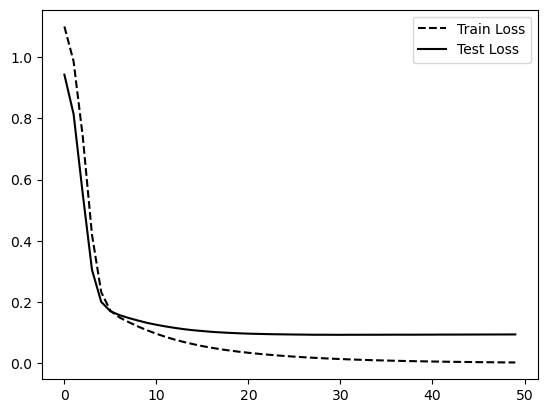

In [38]:
import matplotlib.pyplot as plt
epochs = list(range(num_epochs))
plt.plot(epochs, train_losses, 'k--', label='Train Loss')
plt.plot(epochs, test_losses, 'k-', label='Test Loss')
plt.legend()
plt.show()

In [39]:
def get_preds(net, loader):
    xs = []
    ys = []
    for batch_idx, batch in enumerate(loader):
        inputs, targets = batch
        with torch.no_grad():
            outputs = net(inputs)
            xs.append(inputs)
            ys.append(outputs)
    xs = torch.cat(xs, axis=0)
    ys = torch.cat(ys, axis=0)
    return xs.numpy(), ys.numpy()

In [40]:
from sklearn.metrics import r2_score

train_x, train_preds = get_preds(net, train_loader)
test_x, test_preds = get_preds(net, test_loader)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
print("Train R2: ", train_r2, "Test R2: ", test_r2)

Train R2:  0.9964109401941462 Test R2:  0.9028159210946569


## Feature Learning in Neural Networks

At this point there are two questions: 

1. Why is the Neural Network doing better than the Laplace Kernel? 
2. Why does lowering the scale of initialization lead to better results? 


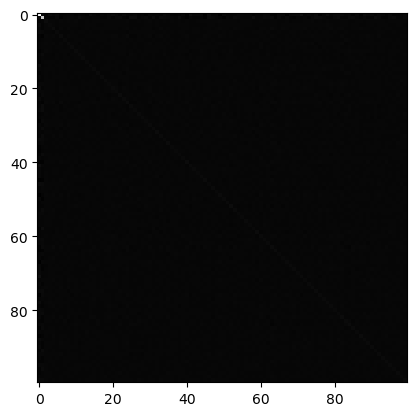

In [41]:
for idx, p in enumerate(net.parameters()):
    if idx == 0:
        B = p.data.numpy()
M = B.T @ B

M = (M - M.min()) / (M.max() - M.min())
plt.imshow(M, cmap='gray')
plt.show()

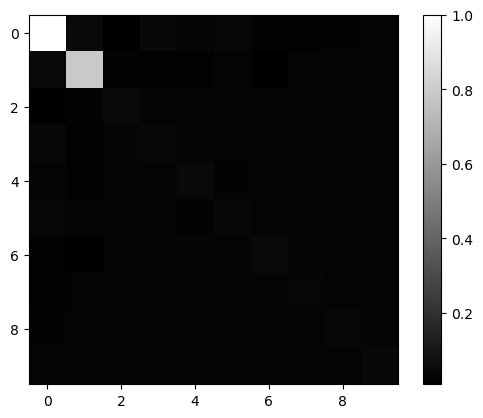

In [42]:
plt.imshow(M[:10, :10], cmap='gray')
plt.colorbar()
plt.show()

## Laplace Kernel on subset features

We saw earlier that Laplace kernel was performing far worse than the neural net.  This is because the neural net was able to subset down to the relevant coordinates in the first layer.  Indeed, if we train a Laplace kernel on just the relevant features, we perform extremely well.  Thus, the natural next question is how is the neural network learning to subset to relevant features?

In [43]:
model = LaplaceKernel()
model = model.fit(X_train.numpy()[:, :2], y_train.numpy(), reg=0)
lap_train_preds = model.predict(X_train.numpy()[:, :2])
lap_test_preds = model.predict(X_test.numpy()[:, :2])
lap_train_r2 = r2_score(y_train, lap_train_preds)
lap_test_r2 = r2_score(y_test, lap_test_preds)
print("Train R2: ", lap_train_r2, "Test R2: ", lap_test_r2)

Train R2:  1.0 Test R2:  0.9971272021690015


## RFM 

We now compare the performance and features learned by RFMs with those of previous models.

In [44]:
import rfm  

model = rfm.RFM()
model = model.fit(X_train.numpy(), y_train.numpy(), num_iters=2, reg=0, 
                  centering=True, verbose=False, diag_only=False)
rfm_train_preds = model.predict(X_train.numpy())
rfm_test_preds = model.predict(X_test.numpy())
rfm_train_r2 = r2_score(y_train, rfm_train_preds)
rfm_test_r2 = r2_score(y_test, rfm_test_preds)
print("Train R2: ", rfm_train_r2, "Test R2: ", rfm_test_r2)

Train R2:  1.0 Test R2:  0.9056830689492937


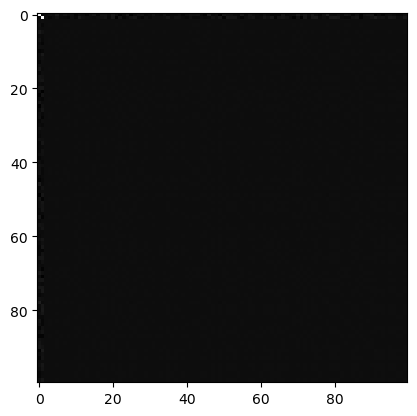

In [45]:
M = model.get_M()
plt.imshow(M, cmap='gray')
plt.show()

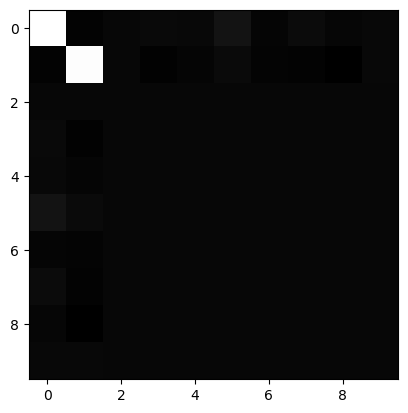

In [46]:
plt.imshow(M[:10, :10], cmap='gray')
plt.show()